In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import seaborn as sns
%matplotlib inline 
from projectworkflow.data import *
from projectworkflow.lstm import *
import csv

import warnings
warnings.filterwarnings('ignore')

In [2]:
keyfile = '../keys/alpha_vantage'
start_date = '2010-01-01'
key = read_key(keyfile)
market = ['XBI']

d = get_data(key, market)

In [3]:
#unpack the dict
df = pd.DataFrame.from_dict(d['XBI'])
df = df.T
#df.index.name = "Date"

#reversed the indexes to the correct chronological order
df = df.iloc[::-1]

In [4]:
adj_close_df = df.drop(['1. open','2. high','3. low','4. close','6. volume','7. dividend amount','8. split coefficient'], axis=1)

#switching dataframe to series to grid search
series = pd.Series(adj_close_df['5. adjusted close'])


In [38]:
test_size = 0.3
train, test = train_test_split(series, test_size)
scale = MinMaxScaler(feature_range=(-1,1))
data = [train, test, scale]
inputs = [5, 10, 20, 30]
nodes = [10, 20, 30]
epochs = [10, 20, 30]
batch_size = [30, 40, 50]
features = [1]

params = parameters(inputs, nodes, epochs, batch_size, features)
results = grid_search(data, params)

# running grid search is computationally intensive so we save the results for future reference.
with open('GS.CSV', mode='w') as w:
    writer = csv.writer(w)
    writer.writerow(['Key','Params','Average Error'])
    writer.writerows(results)


Hyperparams [5, 20, 30, 30, 1] evaluated!


In [65]:
train_scale = scale.fit_transform(train.values.reshape(-1,1))
test_scale = scale.fit_transform(test.values.reshape(-1,1))

train_x, train_y = lstm_dataset(train_scale, 5)
test_x, test_y = lstm_dataset(test_scale, 5)

In [66]:
#np array isnt in the right form to feature scale
vals = adj_close_df['5. adjusted close'].values.reshape(-1,1)
vals = vals.astype('float32')

#normalize the adjusted close values to range from -1 to 1
scaled = scale.fit_transform(vals)

In [67]:
# plugging in the parameters we received from grid searching
rnn = Sequential([LSTM(20, input_shape=(train_x.shape[1], 1))])
#rnn.add(Dropout(0.2))
rnn.add(Dense(1))

rnn.compile(optimizer='adam',loss='mse')
history = rnn.fit(train_x,train_y, epochs=30, batch_size=30, validation_data=(test_x,test_y),shuffle=False, verbose=0)

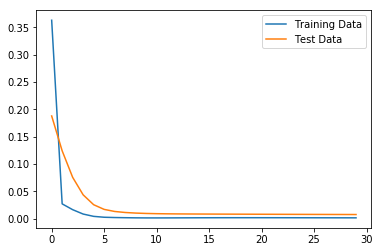

In [68]:
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.legend()

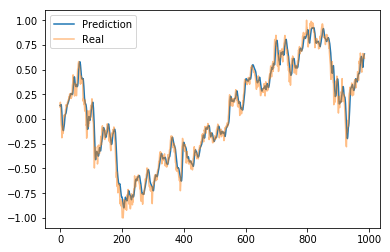

In [69]:
yhat = rnn.predict(test_x)
plt.plot(yhat, label = 'Prediction')
plt.plot(test_y, label = 'Real', alpha=0.5)
plt.legend()

In [70]:
# Change back to real values from normalized ones
yhat_inverse = scale.inverse_transform(yhat.reshape(-1,1))
ytest_inverse = scale.inverse_transform(test_y.reshape(-1,1))

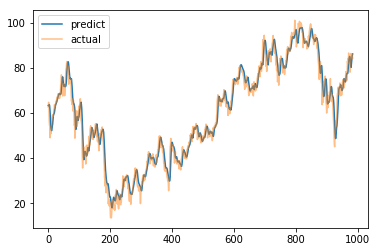

In [71]:
# Plotting real values
plt.plot(yhat_inverse, label ='predict')
plt.plot(ytest_inverse, label='actual', alpha=0.5)
plt.legend()

In [72]:
#Root Mean Squared Error
rmse = round(np.sqrt(mean_squared_error(ytest_inverse,yhat_inverse)),3)
print('Test RMSE: {0:.{1}f}'.format(rmse,3))

Test RMSE: 3.795


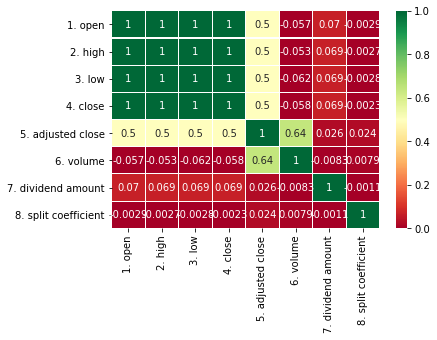

In [73]:
df = df.apply(pd.to_numeric)
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn', linewidths=0.1, vmin=0)

There seems to be a correlation between Volume and Adjusted Close. 

In [75]:
correlation = df[['5. adjusted close'] + ['6. volume']].values

scaled = scale.fit_transform(correlation)

In [82]:
prediction = series_to_supervised(scaled, 1, 1)
prediction.drop(prediction.columns[3], axis=1, inplace=True)

vals = prediction.values
train_len = int(len(vals) * 0.7)
train, test = vals[0:train_len, :], vals[train_len:, :]

x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [83]:
# using the same parameters as the single feature model + 1 feature
multi_feature = Sequential([LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2]))])
#multi_feature.add(Dropout(0.2))
multi_feature.add(Dense(1))
multi_feature.compile(optimizer='adam',loss='mse')
multi_history = multi_feature.fit(x_train, y_train, epochs=30, batch_size=30, validation_data=(x_test,y_test),shuffle=False)


Train on 2310 samples, validate on 991 samples
Epoch 1/30
2310/2310 [==============================] - 10s 4ms/step - loss: 0.3239 - val_loss: 0.4633
Epoch 2/30
2310/2310 [==============================] - 0s 116us/step - loss: 0.1172 - val_loss: 0.5589
Epoch 3/30
2310/2310 [==============================] - 0s 116us/step - loss: 0.0609 - val_loss: 0.5295
Epoch 4/30
2310/2310 [==============================] - 0s 115us/step - loss: 0.0494 - val_loss: 0.4701
Epoch 5/30
2310/2310 [==============================] - 0s 115us/step - loss: 0.0426 - val_loss: 0.4100
Epoch 6/30
2310/2310 [==============================] - 0s 114us/step - loss: 0.0360 - val_loss: 0.3521
Epoch 7/30
2310/2310 [==============================] - 0s 119us/step - loss: 0.0296 - val_loss: 0.2976
Epoch 8/30
2310/2310 [==============================] - 0s 115us/step - loss: 0.0235 - val_loss: 0.2475
Epoch 9/30
2310/2310 [==============================] - 0s 115us/step - loss: 0.0181 - val_loss: 0.2026
Epoch 10/30
2310/2

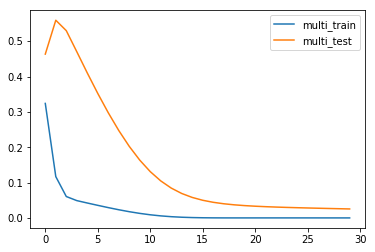

In [84]:
plt.plot(multi_history.history['loss'], label='multi_train')
plt.plot(multi_history.history['val_loss'], label='multi_test')
plt.legend()
plt.show()

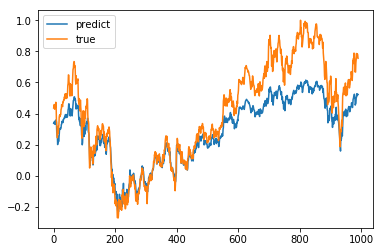

In [85]:
yhat = multi_feature.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [86]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2]))

In [88]:
inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis = 1)
inv_yhat = scale.inverse_transform(inv_yhat)
inv_yhat= inv_yhat[:,0]
inv_yhat

y_test = np.reshape(y_test, (y_test.shape[0], 1))
inv_y = np.concatenate((y_test, x_test[:, 1:]), axis = 1)
inv_y = scale.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [89]:
#Root Mean Squared Error
rmse = round(np.sqrt(mean_squared_error(inv_y,inv_yhat)),3)
print('Test RMSE: {0:.{1}f}'.format(rmse,3))

Test RMSE: 7.033
